# Projekt Open Asteroid Dataset

In diesem Projekt soll auf Grundlage eines Datensatzes von Asteroiden ein Modell erstellt werden, mit dem der `diameter` von Himmelskörpern auf Grundlage bestimmter Features vorhergesagt werden kann. Es handelt sich also um ein Regressions-Problem.

## 1. Einlesen der Datei und Exploration

### 1.1. Importe

In [235]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

### 1.2. Daten einlesen

In diesem Abschnitt wird die `Asteroid_Updated.csv` Datei eingelesen, da diese über mehr Features verfügt als der `Asteroid.csv` Datensatz. Der Datensatz enthält ca. 840k Zeilen und 31 Features.

In [236]:
data = pd.read_csv("Asteroid_Updated.csv", low_memory=False, delimiter=",")

### 1.3. Daten sichten und bearbeiten

Nachfolgend wird sich ein Überblick über die verschiedenen Features verschafft. Zudem soll entschieden werden, welche Spalten aufgrund fehlender Einträge für das Vorgehen irrelevant sind.

In [237]:
data.head()

,name,a,e,i,om,w,q,ad,per_y,data_arc,...,UB,IR,spec_B,spec_T,G,moid,class,n,per,ma
0,Ceres,2.769165,0.076009,10.594067,80.305532,73.597694,2.558684,2.979647,4.608202,8822.0,...,0.426,NaN,C,G,0.12,1.59478,MBA,0.213885,1683.145708,77.372096
1,Pallas,2.772466,0.230337,34.836234,173.080063,310.048857,2.133865,3.411067,4.616444,72318.0,...,0.284,NaN,B,B,0.11,1.23324,MBA,0.213503,1686.155999,59.699133
2,Juno,2.669150,0.256942,12.988919,169.852760,248.138626,1.983332,3.354967,4.360814,72684.0,...,0.433,NaN,Sk,S,0.32,1.03454,MBA,0.226019,1592.787285,34.925016
3,Vesta,2.361418,0.088721,7.141771,103.810804,150.728541,2.151909,2.570926,3.628837,24288.0,...,0.492,NaN,V,V,0.32,1.13948,MBA,0.271609,1325.432765,95.861936
4,Astraea,2.574249,0.191095,5.366988,141.576605,358.687607,2.082324,3.066174,4.130323,63507.0,...,0.411,NaN,S,S,NaN,1.09589,MBA,0.238632,1508.600458,282.366289


In [238]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839714 entries, 0 to 839713
Data columns (total 31 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   name            21967 non-null   object 
 1   a               839712 non-null  float64
 2   e               839714 non-null  float64
 3   i               839714 non-null  float64
 4   om              839714 non-null  float64
 5   w               839714 non-null  float64
 6   q               839714 non-null  float64
 7   ad              839708 non-null  float64
 8   per_y           839713 non-null  float64
 9   data_arc        824240 non-null  float64
 10  condition_code  838847 non-null  object 
 11  n_obs_used      839714 non-null  int64  
 12  H               837025 non-null  float64
 13  neo             839708 non-null  object 
 14  pha             823272 non-null  object 
 15  diameter        137636 non-null  object 
 16  extent          18 non-null      object 
 17  albedo    

#### 1.3.1. Features

` 1.	name
2.	a: semi-major axis(au)
3.	e: eccentricity
4.	G: Magnitude slope parameter 
5.	i: Inclination with respect to x-y ecliptic plane (degree)
6.	om: Longitude oft he ascending node
7.	w: argument of perihelion
8.	q: perihelion distance(au)
9.  ad: aphelion distance(au)
10.	per_y: Orbital periode
11.	data_arc: data_arc-span(d)
12.	condition_code: Orbit condition code
13.	n_obs_used: number of observations used
14.	H: Absolute Magnitude parameter
15.	diameter: Diameter of asteroid(km)
16.	extent: Object bi/tri axial ellipsoid dimensions(Km) 
17.	albedo: geometric albedo
18.	rot_per: Rotation Period(h) 
19.	GM: Standard gravitational parameter, Product of mass and gravitational constant
20.	BV: Color index B-V magnitude difference 
21.	UB: Color index U-B magnitude difference 
22.	IR: Color Index I-R magnitude difference 
23.	spec_B: Spectral taxonomic type (SMASSII) 
24.	spec_T: Spectral taxonomic type(Tholen) 
25.	neo: near Earth objekt  mismatched
26.	pha: Physically Hazardous Asteroid 
27.	moid: Earth Minimum orbit Intersection Distance (au)
28. class: asteroid orbit class
29. n: Mean motion(deg/d)
30. per: orbital Period(d)
31. ma: Mean anomaly(deg)
`


Wie aus obiger Sichtung hervorgeht, enthält der Datensatz viele Features mit fehlenden Daten. Darunter fällt ebenfalls die Zielvariable `diameter`. Zudem wurde deutlich, dass der Datentyp der Zielvariablen transformiert werden muss, da er Variablen sowohl `float` als auch `str` enthält.
Anschließend werden die fehlenden Daten prozentual pro Feature berechnet und es wird bestimmt, welche Features somit für eine Weiterverarbeitung nicht geeignet sind.

In [239]:
count = data.isnull().sum().sort_values(ascending=False)
perc = count / len(data)
missing_data = pd.concat([count, perc], axis=1, keys=["count", "percent"])
missing_data

,count,percent
IR,839713,0.999999
GM,839700,0.999983
extent,839696,0.999979
G,839595,0.999858
UB,838735,0.998834
spec_T,838734,0.998833
BV,838693,0.998784
spec_B,838048,0.998016
rot_per,820918,0.977616
name,817747,0.973840


#### 1.3.2. Unrelevante Daten löschen

Aus der prozentualen Berechnung hat sich ergeben, dass es 11 Features gibt, bei denen mehr als 80% der Daten fehlen. Diese werden als irrelevant eingestuft und nachfolgend gelöscht. Darunter fallen folgende Features: `"albedo", "extent", "rot_per", "GM", "BV", "UB", "IR", "spec_B", "spec_T", "G", "name"`. Obwohl `diameter` ebenfalls nur zu knapp 17% vollständig ist, wird dieses Features dennoch behalten, da es für das Training eines Supervised Learning Modells unentbehrlich ist.

In [240]:
data = data.drop(columns=["albedo", "extent", "rot_per", "GM", "BV", "UB", "IR", "spec_B", "spec_T", "G", "name"])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839714 entries, 0 to 839713
Data columns (total 20 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   a               839712 non-null  float64
 1   e               839714 non-null  float64
 2   i               839714 non-null  float64
 3   om              839714 non-null  float64
 4   w               839714 non-null  float64
 5   q               839714 non-null  float64
 6   ad              839708 non-null  float64
 7   per_y           839713 non-null  float64
 8   data_arc        824240 non-null  float64
 9   condition_code  838847 non-null  object 
 10  n_obs_used      839714 non-null  int64  
 11  H               837025 non-null  float64
 12  neo             839708 non-null  object 
 13  pha             823272 non-null  object 
 14  diameter        137636 non-null  object 
 15  moid            823272 non-null  float64
 16  class           839714 non-null  object 
 17  n         

#### 1.3.3. Transformation und Aufspalten

Wie bereits erwähnt, enthält die Zielvariable verschiedene Datentypen. Aus diesem Grund wird der Datentyp anschließend einheitlich in den Typ `float` umgewandelt. 

In [186]:
data['diameter'] = data['diameter'].astype(float) 

Für besseres Processing der Daten wird `diameter` ans Ende des Datensatzes gestellt und mit der letzten Spalte `ma` vertauscht.

In [187]:
cols = list(data.columns)
a, b = cols.index('diameter'), cols.index('ma')
cols[b], cols[a] = cols[a], cols[b]
data = data[cols]
data.columns

Index(['a', 'e', 'i', 'om', 'w', 'q', 'ad', 'per_y', 'data_arc',
       'condition_code', 'n_obs_used', 'H', 'neo', 'pha', 'ma', 'moid',
       'class', 'n', 'per', 'diameter'],
      dtype='object')

Da die Zielvariable für das Training und die Evaluierung des Modells beim Supervised Learning stets bekannt sein muss, werden im Weiteren nur die Zeilen des Datensatzes verwendet, bei denen ein bekannter `diameter` vorliegt. Diese werden in `data_useful` gespeichert. 

Darüberhinaus sollen die Daten, deren `diameter` unbekannt ist, in `data_useless` für die abschließende Vorhersage gespeichert werden. 

In [188]:
data_useful = data[data.diameter.notna()]
data_useless = data[data.diameter.isna()]

`data_useful` besteht nun aus 137636 und `data_useless` aus 702078 Einträgen und jeweils 20 Features.

Nachfolgend wird der neue Datensatz `data_useful` in Trainings- und Testdaten aufgesplittet. Der Trainingsdatensatz soll hierbei aus 80% des Datensatzes bestehen.

In [9]:
df_train, df_test = train_test_split(data_useful, train_size=.8)

### 1.4. Missing Values

Anschließend wird überprüft, ob der Trainingsdatensatz fehlende Werte aufweist. Ist dies der Fall, müssen diese ergänzt werden. Zusätzlich dazu sollen kategorische und numerische Features gekennzeichnet werden, wobei die kategorischen ihrerseits in nominelle und ordinale Features unterteilt werden.

In [10]:
count = df_train.isnull().sum().sort_values(ascending=False)
perc = count / len(df_train)
missing_data = pd.concat([count+0, perc], axis=1, keys=["count", "percent"])
missing_data

Die Features `H` und `data_arc` enthalten noch fehlende Werte, die im Anschluss durch Imputation hinzugefügt werden.

#### 1.4.1. Kategorische Features

In [11]:
df_train_categorical = df_train.select_dtypes(include="object").astype("category")
# df_train_categorical

##### 1.4.1.1. Ordinale und nominale Features

In [12]:
nominal_columns = ["class"]
nominal_categories = [list(data[column].unique()) for column in nominal_columns]

ordinal_columns = ["condition_code", "neo", "pha"]
ordinal_categories = [
    ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'D', 'E'],
    ['N', 'Y'],
    ['N', 'Y']
]

Das nominelle Feature `class` enthält folgende Kategorien: `'MBA', 'OMB', 'MCA', 'AMO', 'IMB', 'TJN', 'CEN', 'APO', 'ATE', 'AST', 'TNO', 'IEO', 'HYA', 'PAA'`.

Die ordinalen Features `condition_code`, `neo` und `pha` haben folgende Ordnungen:
- `condition_code`: `'0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'D', 'E'`
- `neo`: `'N', 'Y'`
- `pha`: `'N', 'Y'`

#### 1.4.2. Numerische Features

In [13]:
df_numeric = df_train.select_dtypes(include="number")
# df_numeric

In [14]:
numeric_selector = make_column_selector(dtype_include=np.number)
numeric_columns = numeric_selector(df_train.drop(columns=["diameter"]))
# numeric_columns

### 1.5. Trainings- und Testdaten 

Hier erfolgt die Erzeugung von Trainings- und Testdaten aus `df_train` bzw. `df_test` für das Training und die Evaluation der Modelle.

In [15]:
X_train = df_train.loc[:, nominal_columns + ordinal_columns + numeric_columns]
y_train = df_train.loc[:, "diameter"]

X_test = df_test.loc[:, nominal_columns + ordinal_columns + numeric_columns]
y_test = df_test.loc[:, "diameter"]

### 1.6. Fehlende Werte ersetzen

Mit Hilfe des Scikit-Learn `SimpleImputer` Transformers sollen die fehlenden Einträge der Features `H` und `data_arc` komplettiert werden.

In [16]:
# Instantiierung der Transformers
ordinal_imputer = SimpleImputer(strategy="most_frequent") # replace missing using the most frequent value along each column
nominal_imputer = SimpleImputer(strategy="most_frequent") # replace missing using the most frequent value along each column
numeric_imputer = SimpleImputer(strategy="median")        # replace missing values using the median along each column

# Fitting der Transformers mit Trainingsfeatures
ordinal_imputer.fit(X_train.loc[:, ordinal_columns])
nominal_imputer.fit(X_train.loc[:, nominal_columns])
numeric_imputer.fit(X_train.loc[:, numeric_columns])

# Transformation der Trainingsdaten
X_train.loc[:, ordinal_columns] = ordinal_imputer.transform(X_train.loc[:, ordinal_columns])
X_train.loc[:, nominal_columns] = nominal_imputer.transform(X_train.loc[:, nominal_columns])
X_train.loc[:, numeric_columns] = numeric_imputer.transform(X_train.loc[:, numeric_columns])

Erneute Überprüfung, ob es nach der Transformation immernoch fehlende Werte gibt.

In [17]:
count = X_train.isnull().sum().sort_values(ascending=False)
perc = count / len(X_train)
missing_data = pd.concat([count, perc], axis=1, keys=["count", "percent"])
# missing_data

### 1.7. Encoding der nominalen und ordinalen Features

In diesem Abschnitt werden die ordinalen und nominalen Features durch Zahlen ersetzt. Hierfür wird der Scikit-Learn `OrdinalEncoder` für die ordinalen und der `OneHotEncoder` für die nominalen Features verwendet.

In [18]:
# Instantiierung der Transformer
ordinal_encoder = OrdinalEncoder(categories=ordinal_categories)
nominal_encoder = OneHotEncoder(categories=nominal_categories, sparse=False)

# Fitten
ordinal_encoder.fit(X_train.loc[:, ordinal_columns])
nominal_encoder.fit(X_train.loc[:, nominal_columns])

# Transformation der ordinalen und nominalen Trainingsdaten
X_train.loc[:, ordinal_columns] = ordinal_encoder.transform(X_train[ordinal_columns])
X_train_nominal = nominal_encoder.transform(X_train.loc[:, nominal_columns])

# Erzeugen eines neuen DataFrames, in dem die nominalen Features gespeichert werden.
X_train_nominal = pd.DataFrame(X_train_nominal, columns=nominal_encoder.get_feature_names(), index=X_train.index)

# Ersetzen der nominalen Spalten durch neuen DataFrame
X_train= pd.concat(
    (
        X_train_nominal,
        X_train.drop(columns=nominal_columns)
    ), 
    axis=1
)

Das Encoding hat dazugeführt, dass folgende neue Spalten erzeugt und zu `data_useful` hinzugefügt worden sind: `x0_MBA, x0_AMO, x0_TJN, x0_OMB, x0_IMB, x0_APO, x0_MCA, x0_ATE, x0_CEN, x0_TNO, x0_AST`.

### 1.8. Skalieren der numerischen Features

Für die Skalierung der numerischen Features wird der Scikit-Learn `MinMaxScaler` herangezogen. Dieser sorgt dafür, dass sich die Werte der numerischen Features fortan zwischen 0 und 1 bewegen.

In [19]:
scaler = MinMaxScaler()
scaler.fit(X_train[numeric_columns])

X_train.loc[:, numeric_columns] = scaler.transform(X_train[numeric_columns])

#### 1.8.1 Erzeugen einer Pipeline 

Für einen erleichterten Ablauf wird eine Pipeline mit einem `preprocessor` erzeugt, mit dem fehlende nominale sowie numerische Features komplettiert und ordinale Features encoded werden können. 

In [20]:
ordinal_preprocessing = make_pipeline(ordinal_imputer, ordinal_encoder)
nominal_preprocessing = make_pipeline(nominal_imputer, nominal_encoder)
numeric_preprocessing = make_pipeline(numeric_imputer, scaler)

preprocessor = ColumnTransformer(
    [
        ("ordinal_preprocessor", ordinal_preprocessing, ordinal_columns),
        ("nominal_preprocessor", nominal_preprocessing, nominal_columns),
        ("numeric_preprocessor", numeric_preprocessing, numeric_columns),
    ],
    remainder="drop" # non-specified columns are dropped
)

##### 1.8.1.1. Fitten des `preprocessor` mit dem Trainingsdatensatz

In [21]:
preprocessor.fit(df_train);

##### 1.8.1.2. Transformation des Datensatzes

In [22]:
X_train_preprocessed = preprocessor.transform(df_train)

### 1.9. Visualisierung

#### 1.9.1. Histogramm

Zur besseren Darstellung im Histogramm wurden die Werte der Zielvariablen mit dem Logarithmus zur Basis 10 transformiert.

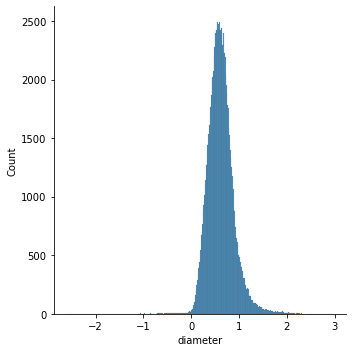

In [171]:
sns.displot(np.log10(df_train.diameter))

#### 1.9.2. Boxplot

Unter Zuhilfenahme eines Boxplots wird deutlich, ob die numerischen Daten korrekt skaliert worden sind.

<AxesSubplot:>

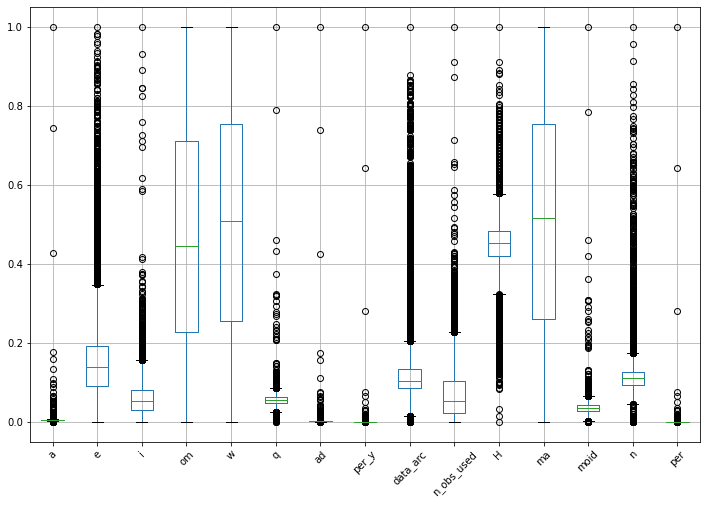

In [25]:
plt.figure(figsize=(12, 8))
X_train[numeric_columns].boxplot(rot=45)

#### 1.9.3. Korrelationsmatrix

Mit Hilfe einer reduzierten Korrelationsmatrix sollen die 5 Features hervorgestellt werden, die am meisten mit der Zielvariablen `diameter` korrelieren. 

In [189]:
red_corr = df_train.corr()
k = 5
best_features = red_corr["diameter"].abs().nlargest(k)
best_features

diameter      1.000000
H             0.576214
data_arc      0.502403
n_obs_used    0.394266
moid          0.348189
Name: diameter, dtype: float64

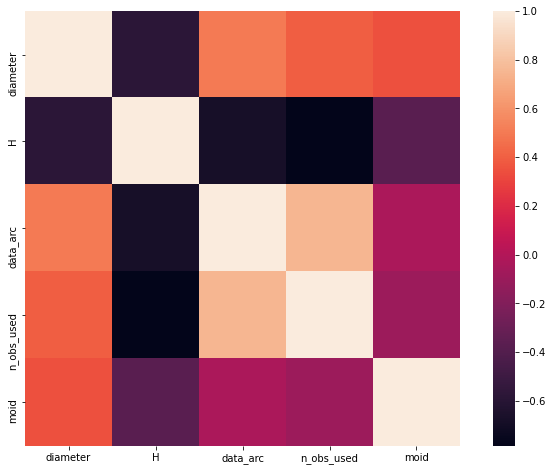

In [190]:
red_corr_best = df_train[best_features.index].corr()

fig = plt.figure(figsize=(12, 8))
sns.heatmap(red_corr_best, square=True);

Aus der reduzierten Korrelationsmatrix geht hervor, dass die Features `H` und `data_arc` besonders stark mit der Größe von Asteroiden korrelieren. Bei `H` handelt es sich um die "Absolute Helligkeit" (Absolute Magnitude Parameter), also die tatsächliche Leuchtkraft eines Asteroiden. `data_arc` beschreibt die Zeitspanne zwischen seiner frühesten und seiner letzten Beobachtung, angegeben in Tagen.

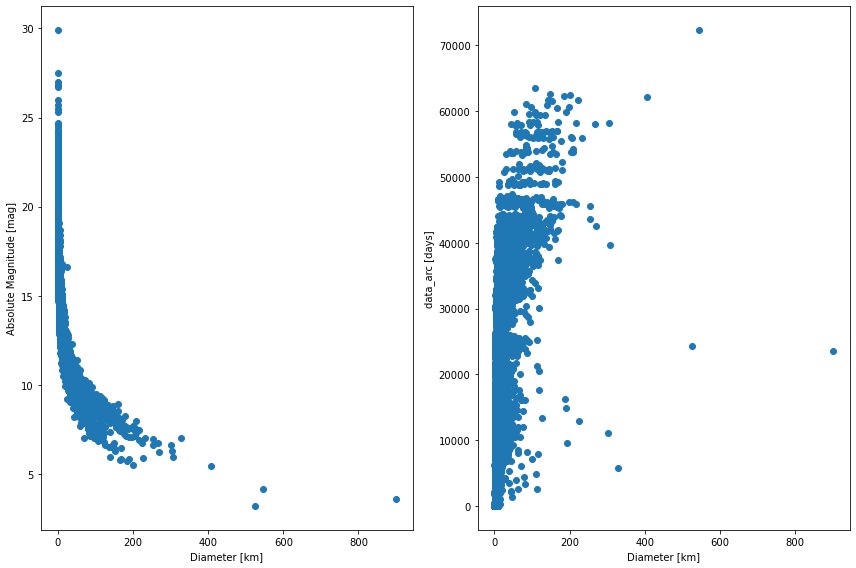

In [191]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.scatter(df_train.diameter, df_train.H)
plt.ylabel("Absolute Magnitude [mag]")
plt.xlabel("Diameter [km]")

plt.subplot(1,2,2)
plt.scatter(df_train.diameter, df_train.data_arc)
plt.ylabel("data_arc [days]")
plt.xlabel("Diameter [km]")
plt.tight_layout()

## 2. Model 1 - `RidgeRegression`

Als erstes Modell soll hier das Modell der `RidgeRegression` angewandt werden. Zur Validierung des Regressionskoeffizienten wird der `r2_score` herangezogen, da er einen Hinweis auf die Anpassungsgüte und damit ein Maß dafür, wie gut ungesehene Stichproben wahrscheinlich durch das Modell vorhergesagt werden können, liefert.

### 2.1. Importe

In [29]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

### 2.2. Modell erzeugen

Das Modell wird innerhalb einer Pipeline erzeugt. Der Grad der Regressionskurve soll sich auf 2 belaufen und die Stärke der Regularisierung wird auf der `default` Einstellung belassen. 

In [30]:
ridge_reg = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False), 
    Ridge(alpha=1.0, normalize=True)
)

#### 2.2.1. Modell fitten

Für eine bessere Performance wird die Zielvariable logarithmiert.

In [31]:
ridge_reg.fit(X_train, np.log(y_train))

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('ridge', Ridge(normalize=True))])

#### 2.2.2. Performance

In [32]:
ridge_reg.score(X_train, np.log(y_train))

0.7859724647151538

### 2.3. Pipeline

Erneute Erzeugung einer Pipeline aus `preprocessor` und `ridge_reg`, um die unvollstänstigen Daten zu kommplettieren und das Modell anschließend zu fitten. 

In [33]:
ridge_and_preprocessor = make_pipeline(preprocessor, ridge_reg)

ridge_and_preprocessor.fit(df_train.drop(columns=["diameter"]), np.log(df_train["diameter"])); 

### 2.4. Evaluierung mit Hilfe der Testdaten

Scoring: `r2_score`.

In [34]:
y_pred_test = ridge_and_preprocessor.predict(df_test.drop(columns=["diameter"]))

ridge_and_preprocessor.score(df_test.drop(columns=["diameter"]), np.log(df_test["diameter"]))

0.7879897809173195

## 3. Modell 2 - `RandomForest`

Da der Regressionskoeffizient beim vorherigen Modell verbesserungswürdig war, wird anschließend ein Modell des Scikit-Learn `RandomForest` zur weiteren Verarbeitung erstellt und evaluiert.

Die Anzahl der Bäume wird auf 500 gesetzt und `max_depth=4`. Das Modell wird zudem auf Over- bzw. Underfitting hin untersucht.

### 3.1. Importe

In [192]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

### 3.2. Modell erzeugen

In [193]:
random_forest = RandomForestRegressor(n_estimators=500, max_depth=4) 

#### 3.2.1. Modell fitten

Da das Logarithmieren der Zielvariablen zum Overfitting geführt hat, wird dieser Schritt für dieses Modell weggelassen.

In [194]:
random_forest.fit(X_train, y_train)

RandomForestRegressor(max_depth=4, n_estimators=500)

#### 3.2.2. Performance

Mit `r2_score`.

In [195]:
random_forest.score(X_train, y_train) 

0.8923353905574765

### 3.3. Pipeline 

Erzeugen einer Pipeline aus `preprocessor` und `random_forest`, um das Modell mit unverarbeiteten Daten evaulieren zu können.

In [196]:
random_forest_and_preprocessor = make_pipeline(preprocessor, random_forest)

#### 3.3.1. Fitting des Modells und des Processors

In [197]:
random_forest_and_preprocessor.fit(df_train.drop(columns=["diameter"]), df_train["diameter"]); 

### 3.4. Evaluation auf den Testdaten

In [253]:
y_pred_test = random_forest_and_preprocessor.predict(df_test.drop(columns=["diameter"]))

#### 3.4.1. Performance

Mit `r2_score`.

In [254]:
random_forest_and_preprocessor.score(df_test.drop(columns=["diameter"]), df_test["diameter"])

0.850484010752597

Aufgrund der Tatsache, dass der `r2_score` des Testdatensatzes nicht sonderlich weit unter dem des Trainingsdatensatzes liegt, ist ein Overfitting auszuschließen.

## 4. Randomisierte Hyperparametersuche

Für die Suche der besten Hyperparameter `max_depth` und `n_estimators` wird eine randomisierte Suche mit Hilfe der `RandomizedSearchCV` Klasse aus Scikit-Learn durchgeführt.

- 3 Kreuzvalidierungsschritte
- 100 Zufallssettings

In [211]:
n_estimators = np.arange(500, 800, 100) # Anzahl Bäume
max_depth = np.arange(3, 10, 1)# Maximale Tiefe

# Random Grid
random_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth
}

In [212]:
random_forest = RandomForestRegressor()
random_forest_HP = RandomizedSearchCV(
    estimator=random_forest, 
    param_distributions=random_grid, 
    n_iter=20, 
    cv=3, 
    scoring="r2",
    n_jobs=-1
)

# !!! DON'T RUN CELL BELOW !!!

In [213]:
# Dauert Ewigkeiten!!
random_forest_HP.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'max_depth': array([3, 4, 5, 6, 7, 8, 9]),
                                        'n_estimators': array([500, 600, 700])},
                   scoring='r2')

# !!! DON'T RUN CELL ABOVE !!!

### 4.1. Beste Parameter

In [218]:
random_forest_HP.best_params_

{'n_estimators': 700, 'max_depth': 8}

#### 4.1.1. Performance

Erneut mit dem `r2_score`.

In [219]:
random_forest_HP.best_score_

0.8606107276372313

Die Hyperparametersuche hat ergeben, dass mit `n_estimators=500` und `max_depth=9` der beste Regressionskoeffizient mit `0.84` erreicht wird.

#### 4.1.2. Bestes Modell

In [220]:
random_forest_HP.best_estimator_

RandomForestRegressor(max_depth=8, n_estimators=700)

## 5. Kreuzvalidierung

Um die Generalisierung von `random_forest_and_preprocessor` noch besser abzuschätzen, wird eine Kreuzvalidierung durchgeführt. 

In [221]:
cv_scores = cross_val_score(
    random_forest_and_preprocessor, 
    df_train.drop(columns=["diameter"]),
    df_train["diameter"],
    cv=15,
)

### 5.1. Generalisierung durch KV

Die Generalisierung des Modells errechnet sich mittels `np.mean(cv_scores)` und beträgt `0.85`.

In [223]:
np.mean(cv_scores)

0.8558862440231353

## 6. Vorhersage auf unbekannten Daten

In diesem Abschnitt wird das Modell auf den `data_useless`Datensatz angewandt, um eine Vorhersage über den Durchmesser treffen zu können. Eine Validierung wird nicht möglich sein, da keine `diameter` bekannt sind.

In [224]:
y_predicted = random_forest_and_preprocessor.predict(data_useless.drop(columns=["diameter"]))

In [244]:
y_predicted

array([13.01508322, 15.97446252,  3.08267893, ...,  3.04625934,
        3.04625934,  3.04625934])

### 6.1. Visualisierung

<ipython-input-252-a6657a27b82c>:16: RuntimeWarning: invalid value encountered in log10
  plt.hist(np.log10(y_pre), bins=100);


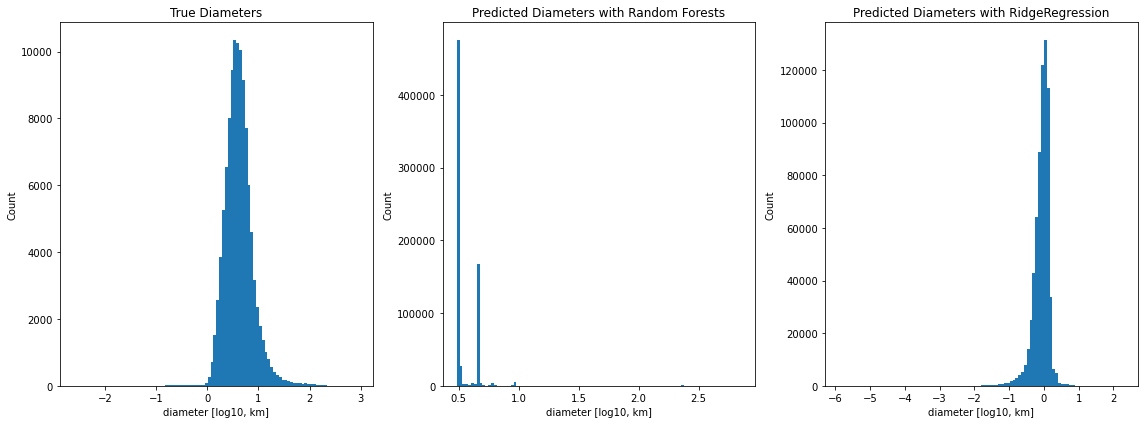

In [252]:
plt.figure(figsize=(8,6))
plt.subplot(1,2,1)
plt.hist(np.log10(df_train.diameter), bins=100);
plt.xlabel("diameter [log10, km]")
plt.ylabel("Count")
plt.title("True Diameters")

plt.subplot(1,2,2)
plt.hist(np.log10(y_predicted), bins=100);
plt.xlabel("diameter [log10, km]")
plt.ylabel("Count")
plt.title("Predicted Diameters")
plt.tight_layout()

In [227]:
y_predicted.max()

712.6091385675822

In [228]:
data_useful.diameter.min(), y_predicted.min()

(0.0025, 3.0462593396272197)

In [229]:
data_useful.diameter.max(), y_predicted.max()

(939.4, 712.6091385675822)

In [230]:
data_useful.diameter.mean(), y_predicted.mean()

(5.4832283014619305, 4.460467724247814)

In [231]:
data_useful.diameter.std(), y_predicted.std()

(9.385734505530076, 15.370834948438837)

In [234]:
data_useless.diameter = y_predicted

In [130]:
red_corr = data_useless.corr()
k = 5
best_features = red_corr["diameter"].abs().nlargest(k)
best_features

diameter    1.000000
moid        0.880093
q           0.878874
H           0.386948
ad          0.293311
Name: diameter, dtype: float64